In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [2]:
mnist=MNIST(root='data', train=True, download=True, transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [3]:
img, label = mnist[0]
print('Label:', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

label: 5


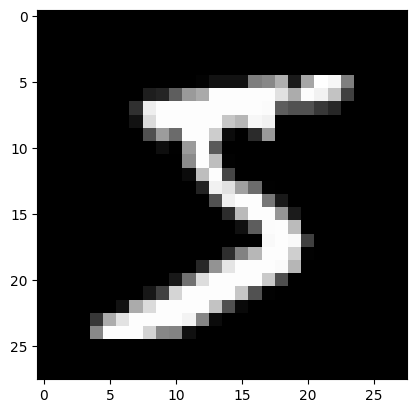

In [5]:
import matplotlib.pyplot as plt
img_norm = denorm(img)

plt.imshow(img_norm[0, :, :], cmap='gray')
print('label:', label)
plt.show()

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
label: tensor([9, 8, 6, 5, 9, 6, 6, 1, 2, 6, 0, 7, 0, 4, 8, 4, 4, 2, 9, 0, 7, 0, 4, 2,
        9, 1, 8, 5, 6, 9, 4, 5, 8, 5, 0, 1, 2, 5, 3, 2, 1, 7, 9, 0, 4, 1, 6, 1,
        0, 1, 9, 7, 0, 1, 3, 2, 6, 9, 7, 6, 9, 7, 3, 2, 5, 9, 1, 6, 1, 5, 5, 4,
        7, 2, 5, 5, 4, 1, 1, 5, 7, 2, 3, 6, 2, 8, 3, 4, 2, 6, 4, 7, 0, 4, 5, 3,
        3, 2, 9, 5])


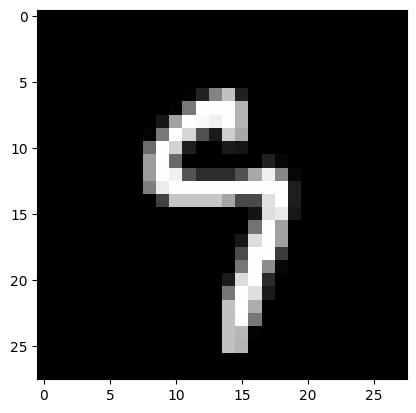

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print('label:', label_batch)
    plt.show()
    break

In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D=nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0,2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0,2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [12]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0, inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0, inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [13]:
latent_size = 64

In [14]:
G=nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(), 
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [15]:
y=G(torch.randn(2, latent_size))
gen_imgs=denorm(y.reshape((-1, 28, 28)).detach())

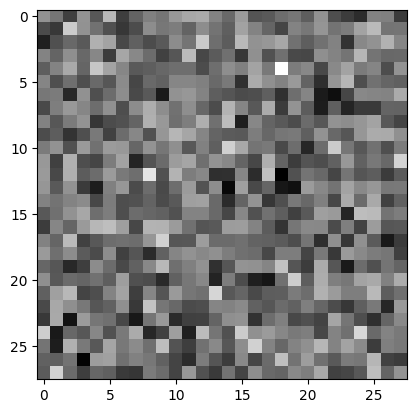

In [16]:
plt.imshow(gen_imgs[0], cmap='gray')

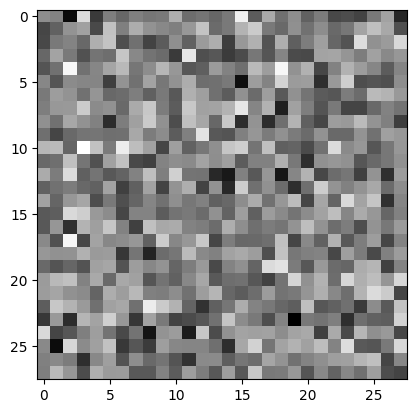

In [17]:
plt.imshow(gen_imgs[1], cmap='gray')

In [18]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [20]:
criterion=nn.BCELoss()
d_optimizer=torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer=torch.optim.Adam(G.parameters(), lr=0.0002)

In [23]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    outputs=D(images)
    d_loss_real=criterion(outputs, real_labels)
    real_score=outputs

    z=torch.randn(batch_size,latent_size).to(device)
    fake_images=G(z)
    outputs=D(fake_images)
    d_loss_fake=criterion(outputs,fake_labels)
    fake_score=outputs

    d_loss=d_loss_real+d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [24]:
z=torch.randn(batch_size, latent_size).to(device)
fake_images=G(z)
D(fake_images)

tensor([[0.4884],
        [0.4892],
        [0.4875],
        [0.4874],
        [0.4886],
        [0.4869],
        [0.4869],
        [0.4875],
        [0.4876],
        [0.4907],
        [0.4883],
        [0.4889],
        [0.4874],
        [0.4886],
        [0.4880],
        [0.4872],
        [0.4895],
        [0.4912],
        [0.4872],
        [0.4878],
        [0.4892],
        [0.4880],
        [0.4881],
        [0.4863],
        [0.4885],
        [0.4875],
        [0.4875],
        [0.4892],
        [0.4880],
        [0.4871],
        [0.4869],
        [0.4888],
        [0.4868],
        [0.4866],
        [0.4881],
        [0.4894],
        [0.4919],
        [0.4883],
        [0.4862],
        [0.4901],
        [0.4889],
        [0.4882],
        [0.4908],
        [0.4875],
        [0.4892],
        [0.4899],
        [0.4880],
        [0.4884],
        [0.4882],
        [0.4878],
        [0.4878],
        [0.4879],
        [0.4884],
        [0.4891],
        [0.4889],
        [0

In [25]:
def train_generator():
    z=torch.randn(batch_size, latent_size).to(device)
    fake_images=G(z)
    labels=torch.ones(batch_size, 1).to(device)
    g_loss=criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [26]:
import os

sample_dir='samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

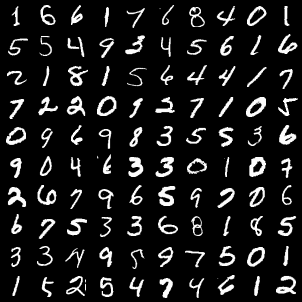

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))


Saving fake_images-0000.png


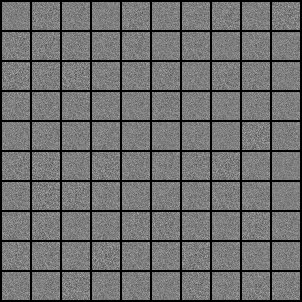

In [29]:
sample_vectors=torch.randn(batch_size, latent_size).to(device)

def save_fake_image(index):
    fake_images=G(sample_vectors)
    fake_images=fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname='fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

save_fake_image(0)

Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [32]:
%%time 

num_epochs=300
total_step=len(data_loader)
d_losses, g_losses, real_scores, fake_scores=[], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images=images.reshape(batch_size,-1).to(device)

        d_loss, real_score, fake_score=train_discriminator(images)
        g_loss,fake_images=train_generator()

        if (i+1)%200==0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
    
    save_fake_image(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.7222, g_loss: 4.0515, D(x): 0.83, D(G(z)): 0.25
Epoch [0/300], Step [400/600], d_loss: 0.5453, g_loss: 3.9389, D(x): 0.81, D(G(z)): 0.08
Epoch [0/300], Step [600/600], d_loss: 0.1987, g_loss: 3.0253, D(x): 0.93, D(G(z)): 0.10
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.6466, g_loss: 2.3699, D(x): 0.79, D(G(z)): 0.19
Epoch [1/300], Step [400/600], d_loss: 1.0237, g_loss: 1.5499, D(x): 0.73, D(G(z)): 0.31
Epoch [1/300], Step [600/600], d_loss: 0.4854, g_loss: 2.7151, D(x): 0.83, D(G(z)): 0.11
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.1520, g_loss: 2.1468, D(x): 0.68, D(G(z)): 0.32
Epoch [2/300], Step [400/600], d_loss: 0.7837, g_loss: 1.6495, D(x): 0.80, D(G(z)): 0.26
Epoch [2/300], Step [600/600], d_loss: 0.3748, g_loss: 3.0361, D(x): 0.89, D(G(z)): 0.11
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2713, g_loss: 2.7559, D(x): 0.91, D(G(z)): 0.11
Epoch [3/300], Step [400/6

KeyboardInterrupt: 

In [33]:
torch.save(G.state_dict(),'G.ckpt')
torch.save(D.state_dict(),'D.ckpt')

In [35]:
import cv2
import os
from IPython.display import FileLink

video_fname='dcgan.avi'

files=[os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()
print(files)

['samples\\fake_images-0000.png', 'samples\\fake_images-0001.png', 'samples\\fake_images-0002.png', 'samples\\fake_images-0003.png', 'samples\\fake_images-0004.png', 'samples\\fake_images-0005.png', 'samples\\fake_images-0006.png', 'samples\\fake_images-0007.png', 'samples\\fake_images-0008.png', 'samples\\fake_images-0009.png', 'samples\\fake_images-0010.png', 'samples\\fake_images-0011.png', 'samples\\fake_images-0012.png', 'samples\\fake_images-0013.png', 'samples\\fake_images-0014.png', 'samples\\fake_images-0015.png', 'samples\\fake_images-0016.png', 'samples\\fake_images-0017.png', 'samples\\fake_images-0018.png', 'samples\\fake_images-0019.png', 'samples\\fake_images-0020.png', 'samples\\fake_images-0021.png', 'samples\\fake_images-0022.png', 'samples\\fake_images-0023.png', 'samples\\fake_images-0024.png', 'samples\\fake_images-0025.png', 'samples\\fake_images-0026.png', 'samples\\fake_images-0027.png', 'samples\\fake_images-0028.png', 'samples\\fake_images-0029.png', 'samples\

In [36]:
vid_fname="gans_training.mp4"
out=cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (302, 302))
[out.write(cv2.imread(fname)) for fname in files]

out.release()
FileLink('gans_training.mp4')

d:\Downloads\Pytorch\gans_training.mp4